In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [23]:
caliper = pd.read_csv(
    '../data/test/caliper_output.txt', 
    sep='|',
    header=0,
    dtype={
        'displacement': np.float64,
        'delay': np.float64
    },
    parse_dates=['time']
)

scale = pd.read_csv(
    "../data/test/scale_output.txt",
    sep='|',
    header=0,
    dtype={
        'weight': np.float64,
        'unit': str,
        'flag': str
    },
    parse_dates=['time']
)

In [24]:
def read_data(caliper_path, scale_path):
    """ Read caliper and scale data """
    caliper = pd.read_csv(
        caliper_path, 
        sep='|',
        header=0,
        dtype={
            'displacement': np.float64,
            'delay': np.float64
        },
        parse_dates=['time']
    )

    caliper.loc[:, 'derr'] = caliper.displacement.diff().abs() / 2
    caliper.loc[0, 'derr'] = caliper.loc[0, 'derr']
    caliper.derr = 0.001 + caliper.derr

    scale = pd.read_csv(
        scale_path,
        sep='|',
        header=0,
        dtype={
            'weight': np.float64,
            'unit': str,
            'flag': str
        },
        parse_dates=['time']
    )
    scale.loc[:, 'ferr'] = scale.weight.diff().abs() / 2
    scale.loc[0, 'ferr'] = scale.loc[1, 'ferr']
    scale.ferr += 0.5
    
    return caliper, scale

In [26]:
caliper, scale = read_data("../data/buckling/caliper_6in_116_1.txt", "../data/buckling/scale_6in_116_1.txt")

In [27]:
def clean_raw_data(caliper:pd.DataFrame, scale:pd.DataFrame):
    """ Clean raw data heads and tails for data matching later """
    scale_start_ind = 0
    while (caliper.time < scale.time.iloc[scale_start_ind]).sum() == 0:
        scale_start_ind += 1
    caliper_start_ind = caliper.index[caliper.time < scale.time.iloc[scale_start_ind]].max()

    scale_end_ind = scale.index.max()
    while (caliper.time > scale.time.iloc[scale_end_ind]).sum() == 0:
        scale_end_ind -= 1
    caliper_end_index = caliper.index[caliper.time > scale.time.iloc[scale_end_ind]].min()
    clean_scale = scale.iloc[scale_start_ind:scale_end_ind + 1]
    clean_caliper = caliper.iloc[caliper_start_ind:caliper_end_index + 1]

    return clean_caliper.reset_index(drop=True), clean_scale.reset_index(drop=True)

In [28]:
ccaliper, cscale = clean_raw_data(caliper=caliper, scale=scale)

,time,displacement,delay,derr
0,2024-08-28 14:58:33.990431,0.004,-0.00214,0.001
1,2024-08-28 14:58:34.121538,0.004,-0.00431,0.001
2,2024-08-28 14:58:34.237329,0.004,0.00865,0.001
3,2024-08-28 14:58:34.359225,0.004,0.01564,0.001
4,2024-08-28 14:58:34.488097,0.004,0.01563,0.001
...,...,...,...,...
225,2024-08-28 14:59:03.117302,1.880,-0.00107,0.034
226,2024-08-28 14:59:03.248136,1.882,0.00292,0.002
227,2024-08-28 14:59:03.372265,1.920,0.00679,0.020
228,2024-08-28 14:59:03.503522,1.982,0.00440,0.032


In [31]:
def interpolate_displacement(caliper:pd.DataFrame, scale:pd.DataFrame):
    """ 
    Interpolate displacement data to match weight readings.
    Assuming slow change in displacement, the interpolation should be decently accurate.
    """
    clpr = np.zeros(scale.shape[0])
    clpr_err = np.zeros(scale.shape[0])
    row_iter = scale.iterrows()
    for row in row_iter:
        # get index for interpolate
        target_time = row[1].time
        clwr_ind = caliper.index[caliper.time < target_time].max()
        cupr_ind = clwr_ind + 1
        # interpolate
        dt_range = (caliper.time.iloc[cupr_ind] - caliper.time.iloc[clwr_ind]).total_seconds()
        dt = (target_time - caliper.time.iloc[clwr_ind]).total_seconds()
        dx_range = caliper.displacement.iloc[cupr_ind] - caliper.displacement.iloc[clwr_ind]
        dx_range_err = caliper.derr.iloc[cupr_ind] + caliper.derr.iloc[clwr_ind]
        clpr[row[0]] = dt / dt_range * dx_range + caliper.displacement.iloc[clwr_ind]
        clpr_err[row[0]] = dt / dt_range * dx_range_err
    return clpr, clpr_err, scale.weight.to_numpy(), scale.ferr.to_numpy()

In [32]:
xls, xerr, wls, werr = interpolate_displacement(caliper=ccaliper, scale=cscale)

<ErrorbarContainer object of 3 artists>

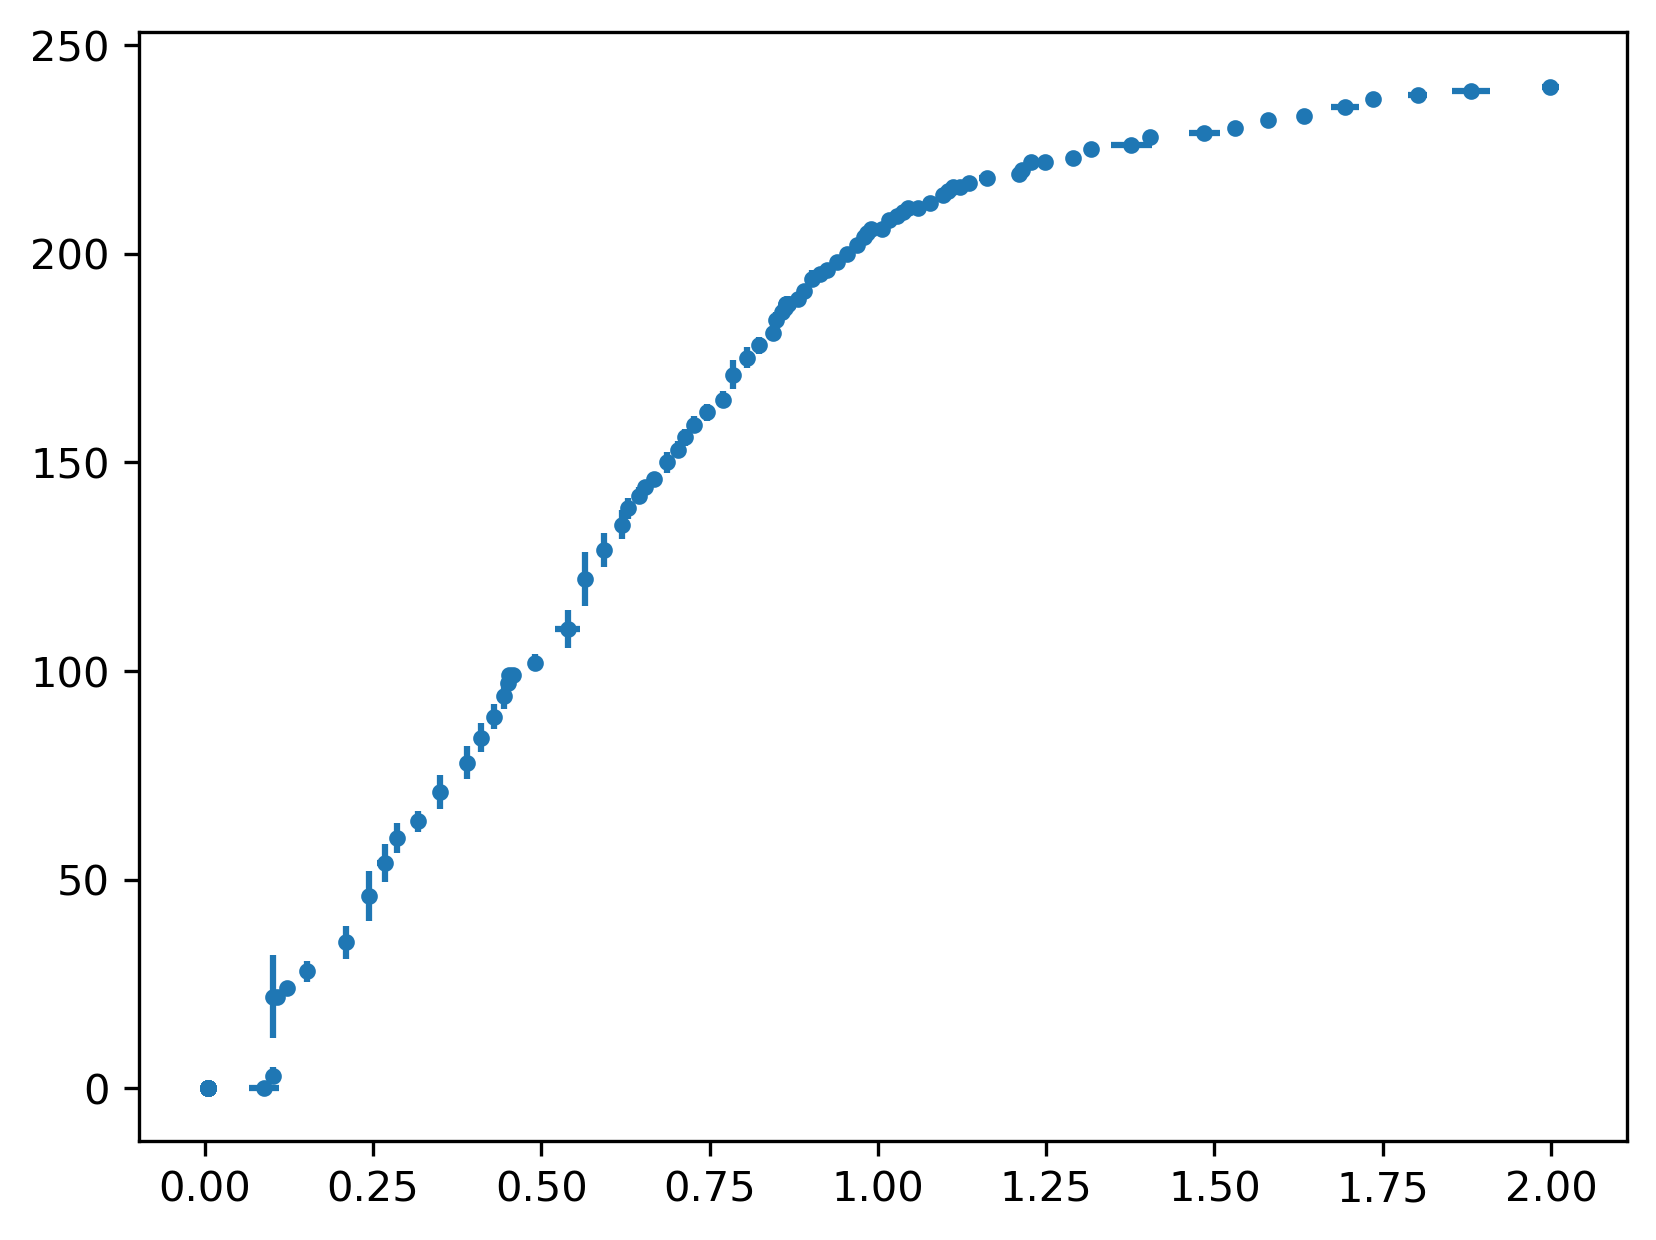

In [36]:
plt.figure(dpi=300)
plt.errorbar(xls, -wls, werr, xerr=xerr, ls='', fmt='.')

In [69]:
r[1].time

Timestamp('2024-08-15 16:27:14.610912')

In [5]:
clp, frc = read_data("../data/buckling/caliper_6in_116_1.txt", "../data/buckling/scale_6in_116_1.txt")

In [14]:
clp.loc[:, 'derr'] = clp.displacement.diff().abs() / 2
clp.loc[0, 'derr'] = clp.loc[0, 'derr']
clp.derr = 0.001 + clp.derr

In [21]:
frc.loc[:, 'ferr'] = frc.weight.diff().abs() / 2
frc.loc[0, 'ferr'] = frc.loc[1, 'ferr']
frc.ferr += 0.5

In [22]:
frc

,time,weight,unit,flag,ferr
0,2024-08-28 14:58:34.106000,0.0,LG,S,0.5
1,2024-08-28 14:58:34.406134,0.0,LG,S,0.5
2,2024-08-28 14:58:34.706085,0.0,LG,S,0.5
3,2024-08-28 14:58:35.006240,0.0,LG,S,0.5
4,2024-08-28 14:58:35.307211,0.0,LG,S,0.5
...,...,...,...,...,...
95,2024-08-28 14:59:02.618174,-237.0,LG,M,1.5
96,2024-08-28 14:59:02.918913,-238.0,LG,M,1.0
97,2024-08-28 14:59:03.219452,-239.0,LG,M,1.0
98,2024-08-28 14:59:03.520211,-240.0,LG,M,1.0
